### Проверяем разладки на всем датасете


In [39]:
import numpy as np
import plotly.express as px
import pandas as pd
from matplotlib import pyplot as plt
import pickle as pkl

In [29]:
class MeanExp:
    """ Экспоненциальное сглаживание для оценки среднего или дисперсии. """
    def __init__(self, new_value_weight):
        self.weight = new_value_weight
        self.value = None

    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = (1 - self.weight) * self.value + self.weight * new_value

class Stat:
    """ Базовый класс для статистических тестов. """
    def __init__(self, threshold, direction="up", init_stat=0.0):
        self.threshold = threshold
        self.direction = direction
        self._stat = init_stat

    def update(self):
        if self._stat > self.threshold:
            return True
        return False

class AdjustedShiryaevRoberts(Stat):
    """ Модифицированная статистика Ширяева-Робертса для обнаружения разладки. """
    def __init__(self, mean_diff, threshold, max_stat=float("+inf"), init_stat=0.0):
        super().__init__(threshold, direction="up", init_stat=init_stat)
        self._mean_diff = mean_diff
        self._max_stat = max_stat

    def update(self, adjusted_value, **kwargs):
        likelihood = np.exp(self._mean_diff * (adjusted_value - self._mean_diff / 2.))
        self._stat = min(self._max_stat, (1. + self._stat) * likelihood)
        return super().update()

# Настройка начальных параметров
alpha = 0.01
beta = 0.05
sigma_diff = 2.0
max_stat = 1e9

# Загрузка данных
file_path = '../data/featurized_dataset.csv'
data = pd.read_csv(file_path, index_col="date", parse_dates=["date"])
timestamps = pd.to_datetime(data.index)
values = data['Balance'].values

# Моделирование на "нормальных" данных для определения порога
n_samples = len(values)
n_normal = int(n_samples * 0.2)  # использование первых 20% данных как "нормальных"

mean_exp_model = MeanExp(new_value_weight=alpha)
var_exp_model = MeanExp(new_value_weight=beta)
sr_model = AdjustedShiryaevRoberts(sigma_diff, float('inf'), max_stat=max_stat)

model_stat_trajectory = []
for x_k in values[:n_normal]:
    mean_estimate = mean_exp_model.value if mean_exp_model.value is not None else 0
    var_estimate = var_exp_model.value if var_exp_model.value is not None else 1

    predicted_diff_value = (x_k - mean_estimate) ** 2
    predicted_diff_mean = var_estimate
    sr_model.update(predicted_diff_value - predicted_diff_mean)

    model_stat_trajectory.append(sr_model._stat)
    mean_exp_model.update(x_k)
    var_exp_model.update(predicted_diff_value)

threshold_statistical = np.percentile(model_stat_trajectory, 95)

# Обнаружение разладки
sr = AdjustedShiryaevRoberts(sigma_diff, threshold_statistical, max_stat=max_stat)
mean_exp = MeanExp(new_value_weight=alpha)
var_exp = MeanExp(new_value_weight=beta)

stat_trajectory, mean_values, var_values, diff_values, changepoint = [], [], [], [], []
for ts, x_k in zip(timestamps, values):
    mean_estimate = mean_exp.value if mean_exp.value is not None else 0
    var_estimate = var_exp.value if var_exp.value is not None else 1

    predicted_diff_value = (x_k - mean_estimate) ** 2
    predicted_diff_mean = var_estimate
    if sr.update(predicted_diff_value - predicted_diff_mean):
        changepoint.append(ts)

    diff_values.append(predicted_diff_value - predicted_diff_mean)
    mean_exp.update(x_k)
    var_exp.update(predicted_diff_value)
    stat_trajectory.append(sr._stat)
    mean_values.append(mean_estimate

)
    var_values.append(np.sqrt(var_estimate))

# Вывод результатов
print("Обнаруженные разладки:", changepoint)

Обнаруженные разладки: [Timestamp('2017-02-09 00:00:00'), Timestamp('2017-03-27 00:00:00'), Timestamp('2017-03-28 00:00:00'), Timestamp('2017-03-29 00:00:00'), Timestamp('2017-03-30 00:00:00'), Timestamp('2017-05-23 00:00:00'), Timestamp('2017-05-26 00:00:00'), Timestamp('2017-07-20 00:00:00'), Timestamp('2017-07-21 00:00:00'), Timestamp('2017-07-24 00:00:00'), Timestamp('2017-07-26 00:00:00'), Timestamp('2017-09-28 00:00:00'), Timestamp('2017-10-31 00:00:00'), Timestamp('2017-11-01 00:00:00'), Timestamp('2017-11-03 00:00:00'), Timestamp('2017-11-29 00:00:00'), Timestamp('2017-12-15 00:00:00'), Timestamp('2017-12-18 00:00:00'), Timestamp('2017-12-19 00:00:00'), Timestamp('2017-12-20 00:00:00'), Timestamp('2017-12-25 00:00:00'), Timestamp('2017-12-26 00:00:00'), Timestamp('2018-01-09 00:00:00'), Timestamp('2018-01-15 00:00:00'), Timestamp('2018-01-16 00:00:00'), Timestamp('2018-01-17 00:00:00'), Timestamp('2018-01-18 00:00:00'), Timestamp('2018-01-19 00:00:00'), Timestamp('2018-02-27 00

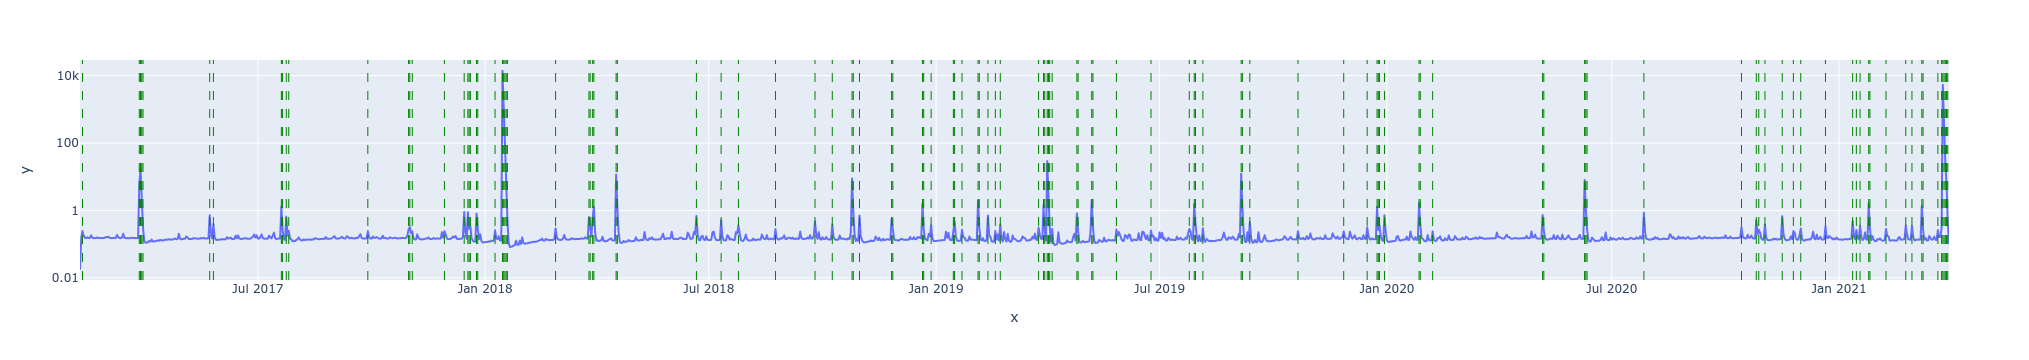

In [30]:
fig = px.line(x = timestamps, y =stat_trajectory, log_y = True)
for i in changepoint:
  fig.add_vline(x=i, line_width=1,line_dash="dash" ,line_color="green")
fig.show()

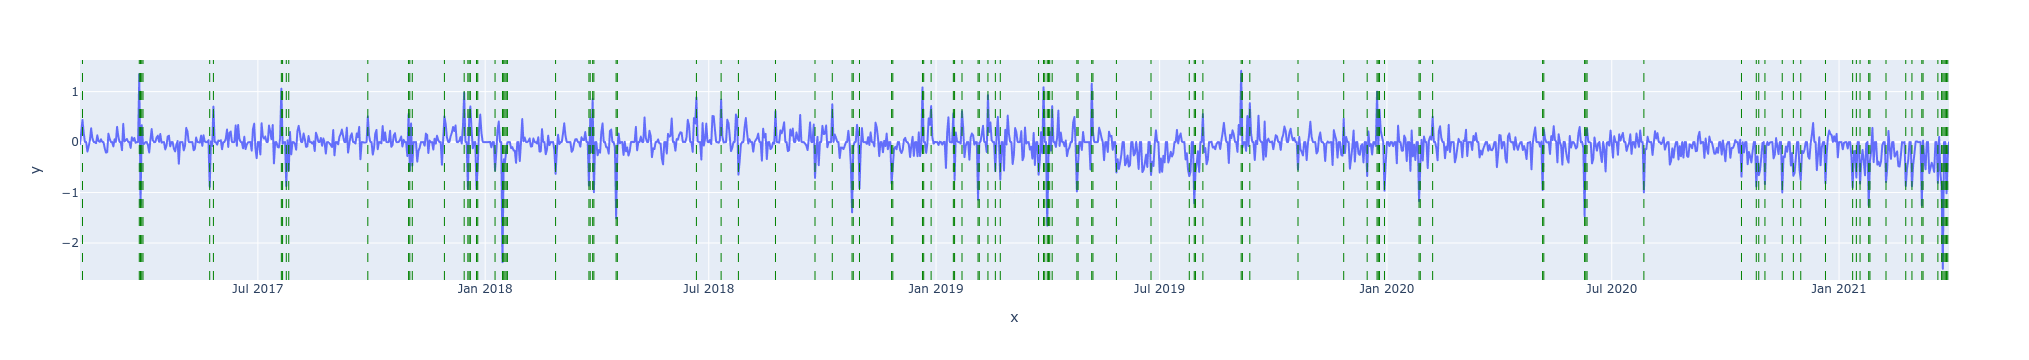

In [31]:
fig = px.line(x=timestamps, y=values)
for i in changepoint:
  fig.add_vline(x=i, line_width=1,line_dash="dash" ,line_color="green")
fig.show()

(array([30., 28.,  0., 22.,  0., 16., 18.,  0.,  3.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

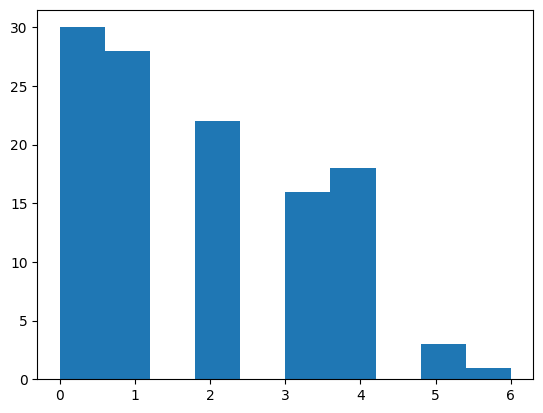

In [32]:
# распределение по дням недели
plt.hist([point.dayofweek for point in changepoint])

(array([ 8.,  7., 10.,  7.,  5., 11.,  9., 10., 31., 20.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

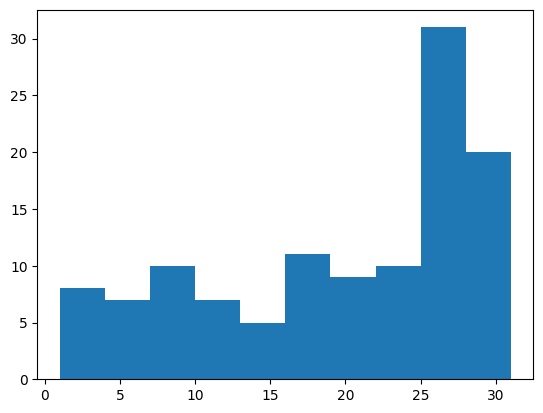

In [33]:
# предсказуемо большинство аномалий приходится на налоговые дни, 25 и 28 число -- в случае праздников они могут смещаться на следующий в основном понедельник, чем объясняется верхний график
plt.hist([point.day for point in changepoint])

In [41]:
with open("../model/changepoints.pkl", "wb") as f:
    pkl.dump(changepoint, f)

### Проверяем разладки в 'онлайн режиме'

In [6]:
# Загрузка данных - здесь нужно написать просто взять тот период, который за который мы хотим
# проверять разладку ( последний месяц или с момента прошлой разладки)
# values - данные
# x_k - новое значение
def change_point_check(values, x_k):
  model_stat_trajectory = []
  ch_point = ''
  for x_k in values[:n_normal]:
      mean_estimate = mean_exp_model.value if mean_exp_model.value is not None else 0
      var_estimate = var_exp_model.value if var_exp_model.value is not None else 1

      predicted_diff_value = (x_k - mean_estimate) ** 2
      predicted_diff_mean = var_estimate
      sr_model.update(predicted_diff_value - predicted_diff_mean)

      model_stat_trajectory.append(sr_model._stat)
      mean_exp_model.update(x_k)
      var_exp_model.update(predicted_diff_value)

  threshold_statistical = np.percentile(model_stat_trajectory, 99)

  # Обнаружение разладки
  sr = AdjustedShiryaevRoberts(sigma_diff, threshold_statistical, max_stat=max_stat)
  mean_exp = MeanExp(new_value_weight=alpha)
  var_exp = MeanExp(new_value_weight=beta)

  stat_trajectory, mean_values, var_values, diff_values, changepoint = [], [], [], [], []
  mean_estimate = mean_exp.value if mean_exp.value is not None else 0
  var_estimate = var_exp.value if var_exp.value is not None else 1

  predicted_diff_value = (x_k - mean_estimate) ** 2
  predicted_diff_mean = var_estimate
  if sr.update(predicted_diff_value - predicted_diff_mean):
    ch_point = 'Обнаружена разладка'
  return ch_point